In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import fft, fftfreq
import scipy.signal as signal
import imageio
import sys
from scipy.signal import butter, lfilter, get_window, medfilt, savgol_filter
import pywt
import seaborn as sns
from scipy.stats import spearmanr, pearsonr
from sklearn.decomposition import PCA
import statsmodels.graphics.tsaplots as tsaplots
import random

In [30]:
sys.path.append("../")

In [31]:
import scripts.denoising_models as denoising_models

In [32]:
gt_df = pd.read_csv("../data/raw/train_labels.csv")

In [33]:
# train_df = np.load("../data/host_processed/data_train.npy")
target_star_list = gt_df.planet_id
target_star = target_star_list[random.randint(1, 673)]

train_df = np.load(f"../data/processed/{target_star}_airs.npy")
gt_df_star = gt_df[gt_df.planet_id == target_star].values[0][:1:-1]

In [34]:
# Introduce smoothing functions parameters

# Median filter for 1D time series
median_window_size = 5


# FFT denoising:
cutoff_freq = 0.0005  # Hz
sampling_rate = 1 / (7.5 * 3600 / 185)  # Hz
order = 4

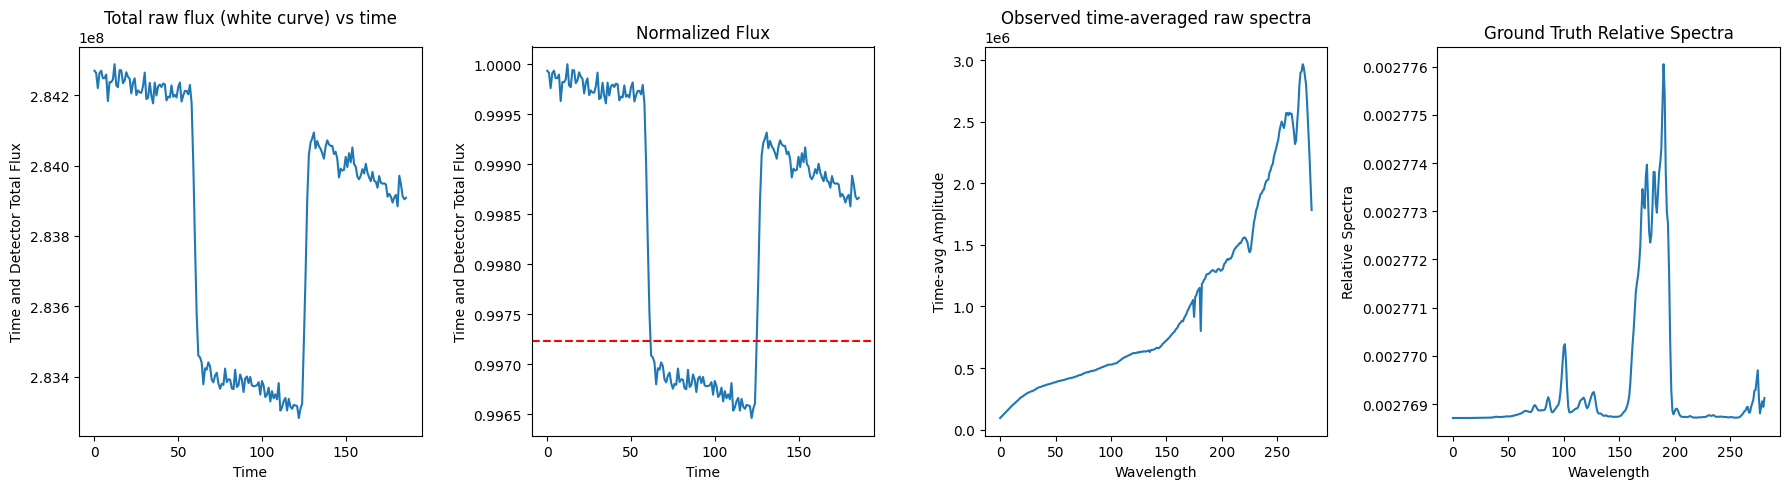

In [35]:
fig, axs = plt.subplots(1, 4, figsize=(18, 5))

# Avg light curve and spectra
axs[0].plot(train_df[0].sum(axis=(1, 2)))
axs[0].set_xlabel("Time")
axs[0].set_ylabel("Time and Detector Total Flux")
axs[0].set_title("Total raw flux (white curve) vs time")

axs[1].plot(train_df[0].sum(axis=(1, 2)) / np.max(train_df[0].sum(axis=(1, 2))))
axs[1].axhline(y=1 - np.mean(gt_df_star), color="r", linestyle="--", label="GT")
axs[1].set_xlabel("Time")
axs[1].set_ylabel("Time and Detector Total Flux")
axs[1].set_title("Normalized Flux")

axs[2].plot(train_df[0].sum(axis=2).mean(axis=0))
axs[2].set_xlabel("Wavelength")
axs[2].set_ylabel("Time-avg Amplitude")
axs[2].set_title("Observed time-averaged raw spectra")

axs[3].plot(gt_df[gt_df.planet_id == target_star].values[0][:1:-1])
axs[3].set_xlabel("Wavelength")
axs[3].set_ylabel("Relative Spectra")
axs[3].set_title("Ground Truth Relative Spectra")

plt.tight_layout()
plt.show()

/var/folders/zy/f29cfj3n6s74jwqsbwmjd8yc0000gn/T/ipykernel_34110/2749731634.py:19: RankWarning: Polyfit may be poorly conditioned
  coefficients_2 = np.polyfit(time_out_of_transit_2, flux_out_of_transit_2, deg=degree)


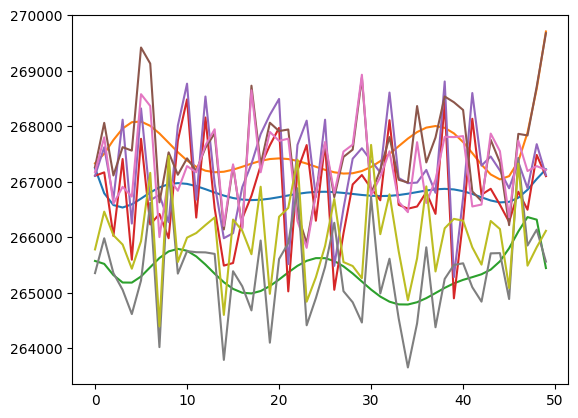

In [1049]:
time_out_of_transit_1 = np.linspace(0, 50, 50)
flux_out_of_transit_1 = train_df[0][:50].sum(axis=(1, 2))
flux_out_of_transit_1 = train_df[0][:50, 20].sum(axis=(1))

time_out_of_transit_2 = np.linspace(130, 180, 50)
flux_out_of_transit_2 = train_df[0][-50:].sum(axis=(1, 2))
flux_out_of_transit_2 = train_df[0][-50:, 20].sum(axis=(1))

time_out_of_transit_3 = np.linspace(70, 120, 50)
flux_out_of_transit_3 = train_df[0][70:120].sum(axis=(1, 2))
flux_out_of_transit_3 = train_df[0][70:120, 20].sum(axis=(1))


degree = 10  # Adjust degree based on your data

coefficients_1 = np.polyfit(time_out_of_transit_1, flux_out_of_transit_1, deg=degree)
poly_trend_1 = np.polyval(coefficients_1, time_out_of_transit_1)¡

coefficients_2 = np.polyfit(time_out_of_transit_2, flux_out_of_transit_2, deg=degree)
poly_trend_2 = np.polyval(coefficients_2, time_out_of_transit_2)

coefficients_3 = np.polyfit(time_out_of_transit_3, flux_out_of_transit_3, deg=degree)
poly_trend_3 = np.polyval(coefficients_3, time_out_of_transit_3)


plt.plot(poly_trend_1)
plt.plot(poly_trend_2)
plt.plot(poly_trend_3)

plt.plot(flux_out_of_transit_1)
oot_corrected_1 = flux_out_of_transit_1 - poly_trend_1 + poly_trend_1[0]
plt.plot(oot_corrected_1)

plt.plot(flux_out_of_transit_2)
oot_corrected_2 = (flux_out_of_transit_2 - poly_trend_2 + poly_trend_2[0]) * (
    poly_trend_1[0] / poly_trend_2[0]
)
plt.plot(oot_corrected_2)

plt.plot(flux_out_of_transit_3)
in_transit_corrected = (
    flux_out_of_transit_3
    - poly_trend_3
    + oot_corrected_1[-1]
    - (flux_out_of_transit_1[-1] - flux_out_of_transit_3[1])
    # - poly_trend_1[10]
)
plt.plot(in_transit_corrected)

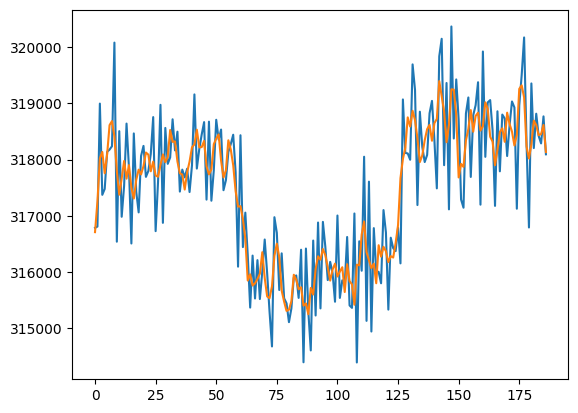

In [1081]:
data_series = train_df[0][:, 30, :].sum(axis=(1))
plt.plot(data_series)
plt.plot(savgol_filter(data_series, 10, 5))

In [1052]:
poly_calibrate = denoising_models.calibrate_signal(train_df[0][:, 20].sum(axis=(1)))

poly_calibrate[0]

np.float64(0.011856250000000047)

In [1065]:
denoising_models.phase_detector(train_df[0][:, 20, :].sum(axis=(1)))

(42, 109)

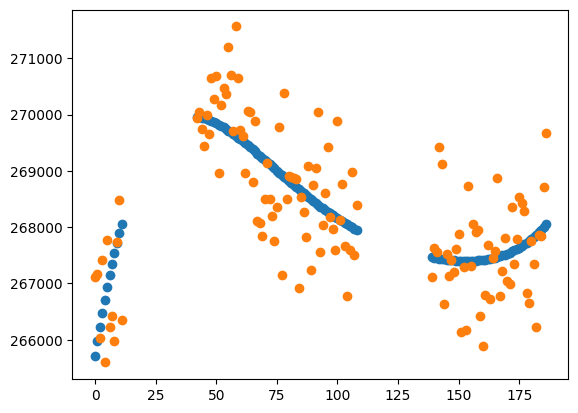

In [1053]:
plt.scatter(poly_calibrate[1], poly_calibrate[3])
plt.scatter(poly_calibrate[1], poly_calibrate[2])

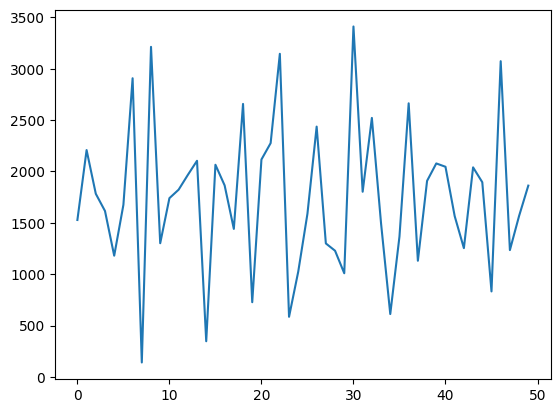

In [1054]:
plt.plot(
    flux_out_of_transit_3
    - poly_trend_3
    + flux_out_of_transit_1[-1]
    - flux_out_of_transit_3[0]
)

In [ ]:
plt.plot(np.concatenate((oot_corrected_1, in_transit_corrected, oot_corrected_2)))

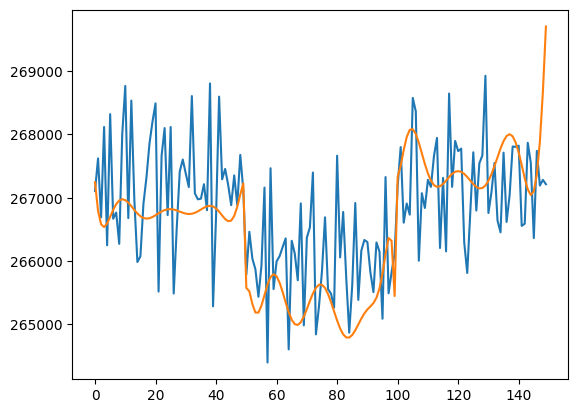

In [1055]:
plt.plot(np.concatenate((oot_corrected_1, in_transit_corrected, oot_corrected_2)))
plt.plot(np.concatenate((poly_trend_1, poly_trend_3, poly_trend_2)))
# plt.plot(train_df[0].sum(axis=(1, 2)))

In [1056]:
gt_df_star[::-1][50]

np.float64(0.0065119203644248)

In [1057]:
print(f"poly prediction = {poly_calibrate[0]}")
print(
    f"prediction = {1-in_transit_corrected.mean() / np.concatenate((oot_corrected_1, oot_corrected_2)).mean()}"
)
print(f"ground truth {np.mean(gt_df_star)}")

poly prediction = 0.011856250000000047
prediction = 0.004653579585113143
ground truth 0.0065119940353541425


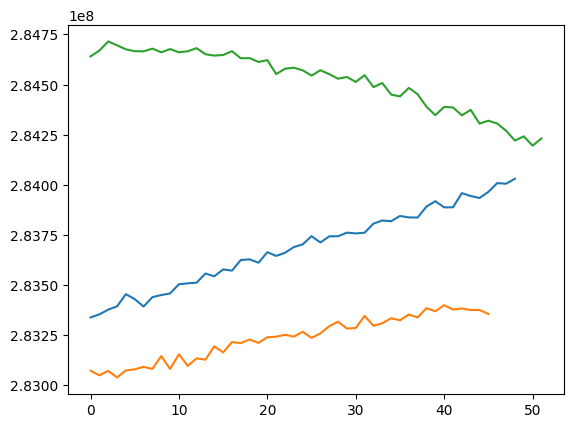

In [601]:
# Light curve transition parameters
p1 = np.argmin(train_df[0].sum(axis=(1, 2))[1:] - train_df[0].sum(axis=(1, 2))[0:-1])
p2 = np.argmax(train_df[0].sum(axis=(1, 2))[1:] - train_df[0].sum(axis=(1, 2))[0:-1])
buffer = 10

# check:
plt.plot(train_df[0].sum(axis=(1, 2))[: p1 - buffer])
plt.plot(train_df[0].sum(axis=(1, 2))[p1 + buffer : p2 - buffer])
plt.plot(train_df[0].sum(axis=(1, 2))[p2 + buffer :])
plt.show()

In [602]:
# Create various light curves for illustration
wavelength_1 = 20
wavelength_2 = 181
wavelength_3 = 273

lc_raw_1 = (
    train_df[0][:, wavelength_1, :].sum(axis=(1)) - train_df[0][:, wavelength_1, 2] * 32
)
lc_raw_2 = (
    train_df[0][:, wavelength_2, :].sum(axis=(1)) - train_df[0][:, wavelength_2, 2] * 32
)
lc_raw_3 = (
    train_df[0][:, wavelength_3, :].sum(axis=(1)) - train_df[0][:, wavelength_3, 2] * 32
)

lc_raw_oot_1 = np.hstack((lc_raw_1[: p1 - buffer], lc_raw_1[p2 + buffer :])).mean()
lc_raw_it_1 = lc_raw_1[p1 + buffer : p2 - buffer].mean()
lc_raw_oot_2 = np.hstack((lc_raw_2[: p1 - buffer], lc_raw_2[p2 + buffer :])).mean()
lc_raw_it_2 = lc_raw_2[p1 + buffer : p2 - buffer].mean()
lc_raw_oot_3 = np.hstack((lc_raw_3[: p1 - buffer], lc_raw_3[p2 + buffer :])).mean()
lc_raw_it_3 = lc_raw_3[p1 + buffer : p2 - buffer].mean()


lc_med_1 = medfilt(lc_raw_1, kernel_size=median_window_size)
lc_med_2 = medfilt(lc_raw_2, kernel_size=median_window_size)
lc_med_3 = medfilt(lc_raw_3, kernel_size=median_window_size)

lc_fft_1 = denoising_models.fft_smmoothing(
    lc_raw_1, sampling_rate, order, cutoff_freq, normalized=True
)
lc_fft_1 = lc_fft_1.reshape(len(lc_fft_1))
lc_fft_2 = denoising_models.fft_smmoothing(
    lc_raw_2, sampling_rate, order, cutoff_freq, normalized=True
)
lc_fft_2 = lc_fft_2.reshape(len(lc_fft_2))
lc_fft_3 = denoising_models.fft_smmoothing(
    lc_raw_3, sampling_rate, order, cutoff_freq, normalized=True
)
lc_fft_3 = lc_fft_3.reshape(len(lc_fft_3))

lc_fft_oot_1 = np.hstack((lc_fft_1[: p1 - buffer], lc_fft_1[p2 + buffer :])).mean()
lc_fft_it_1 = lc_fft_1[p1 + buffer : p2 - buffer].mean()
lc_fft_oot_2 = np.hstack((lc_fft_2[: p1 - buffer], lc_fft_2[p2 + buffer :])).mean()
lc_fft_it_2 = lc_fft_2[p1 + buffer : p2 - buffer].mean()
lc_fft_oot_3 = np.hstack((lc_fft_3[: p1 - buffer], lc_fft_3[p2 + buffer :])).mean()
lc_fft_it_3 = lc_fft_3[p1 + buffer : p2 - buffer].mean()

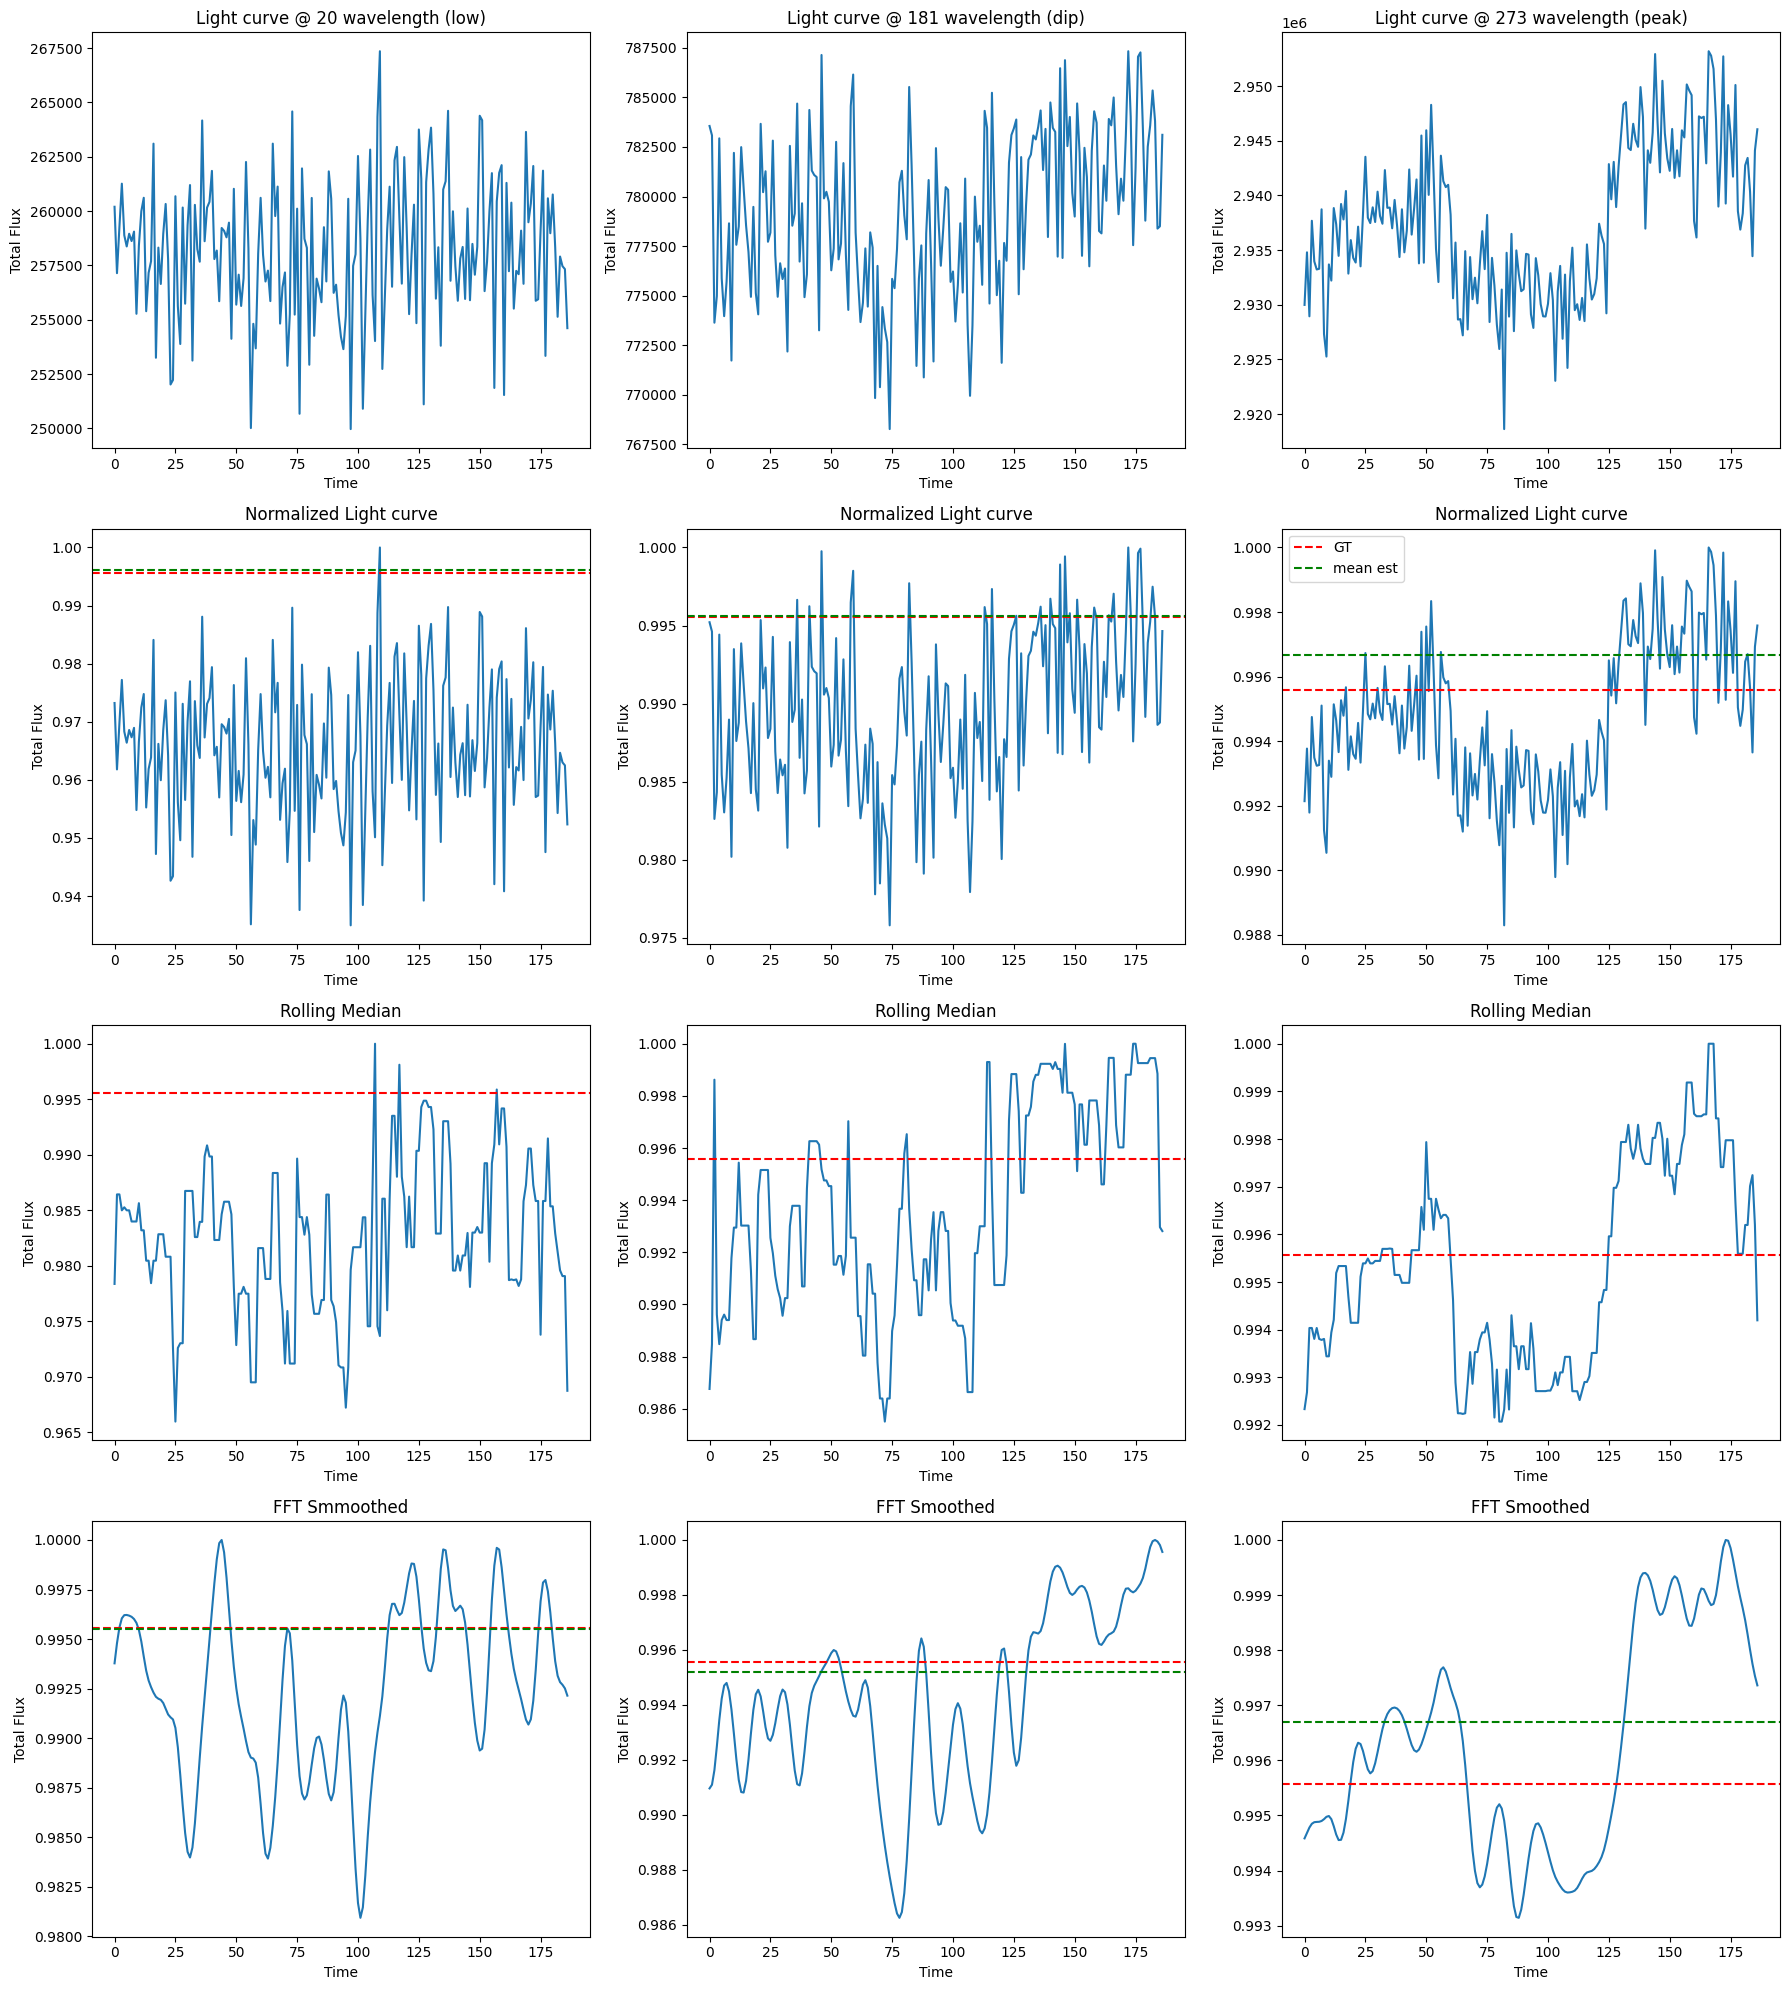

In [603]:
# Illustrate noise per light curve

fig, axs = plt.subplots(4, 3, figsize=(18, 20))

axs[0, 0].plot(lc_raw_1)
axs[0, 0].set_xlabel("Time")
axs[0, 0].set_ylabel("Total Flux")
axs[0, 0].set_title("Light curve @ 20 wavelength (low)")

axs[0, 1].plot(lc_raw_2)
axs[0, 1].set_xlabel("Time")
axs[0, 1].set_ylabel("Total Flux")
axs[0, 1].set_title("Light curve @ 181 wavelength (dip)")

axs[0, 2].plot(lc_raw_3)
axs[0, 2].set_xlabel("Time")
axs[0, 2].set_ylabel("Total Flux")
axs[0, 2].set_title("Light curve @ 273 wavelength (peak)")

axs[1, 0].plot(lc_raw_1 / np.max(lc_raw_1))
axs[1, 0].axhline(y=1 - gt_df_star[wavelength_1], color="r", linestyle="--", label="GT")
axs[1, 0].axhline(
    y=lc_raw_it_1 / lc_raw_oot_1, color="g", linestyle="--", label="mean est"
)
axs[1, 0].set_xlabel("Time")
axs[1, 0].set_ylabel("Total Flux")
axs[1, 0].set_title("Normalized Light curve")

axs[1, 1].plot(lc_raw_2 / np.max(lc_raw_2))
axs[1, 1].axhline(y=1 - gt_df_star[wavelength_2], color="r", linestyle="--", label="GT")
axs[1, 1].axhline(
    y=lc_raw_it_2 / lc_raw_oot_2, color="g", linestyle="--", label="mean est"
)
axs[1, 1].set_xlabel("Time")
axs[1, 1].set_ylabel("Total Flux")
axs[1, 1].set_title("Normalized Light curve")

axs[1, 2].plot(lc_raw_3 / np.max(lc_raw_3))
axs[1, 2].set_xlabel("Time")
axs[1, 2].axhline(y=1 - gt_df_star[wavelength_3], color="r", linestyle="--", label="GT")
axs[1, 2].axhline(
    y=lc_raw_it_3 / lc_raw_oot_3, color="g", linestyle="--", label="mean est"
)
axs[1, 2].set_ylabel("Total Flux")
axs[1, 2].set_title("Normalized Light curve")
axs[1, 2].legend()

axs[2, 0].plot(lc_med_1 / np.max(lc_med_1))
axs[2, 0].set_xlabel("Time")
axs[2, 0].axhline(y=1 - gt_df_star[wavelength_1], color="r", linestyle="--", label="GT")
axs[2, 0].set_ylabel("Total Flux")
axs[2, 0].set_title("Rolling Median")

axs[2, 1].plot(lc_med_2 / np.max(lc_med_2))
axs[2, 1].axhline(y=1 - gt_df_star[wavelength_2], color="r", linestyle="--", label="GT")
axs[2, 1].set_xlabel("Time")
axs[2, 1].set_ylabel("Total Flux")
axs[2, 1].set_title("Rolling Median")

axs[2, 2].plot(lc_med_3 / np.max(lc_med_3))
axs[2, 2].axhline(y=1 - gt_df_star[wavelength_3], color="r", linestyle="--", label="GT")
axs[2, 2].set_xlabel("Time")
axs[2, 2].set_ylabel("Total Flux")
axs[2, 2].set_title("Rolling Median")

axs[3, 0].plot(lc_fft_1 / np.max(lc_fft_1))
axs[3, 0].set_xlabel("Time")
axs[3, 0].axhline(y=1 - gt_df_star[wavelength_1], color="r", linestyle="--", label="GT")
axs[3, 0].axhline(
    y=lc_fft_it_1 / lc_fft_oot_1, color="g", linestyle="--", label="mean est"
)
axs[3, 0].set_ylabel("Total Flux")
axs[3, 0].set_title("FFT Smmoothed")

axs[3, 1].plot(lc_fft_2 / np.max(lc_fft_2))
axs[3, 1].axhline(y=1 - gt_df_star[wavelength_2], color="r", linestyle="--", label="GT")
axs[3, 1].axhline(
    y=lc_fft_it_2 / lc_fft_oot_2, color="g", linestyle="--", label="mean est"
)
axs[3, 1].set_xlabel("Time")
axs[3, 1].set_ylabel("Total Flux")
axs[3, 1].set_title("FFT Smoothed")

axs[3, 2].plot(lc_fft_3 / np.max(lc_fft_3))
axs[3, 2].axhline(y=1 - gt_df_star[wavelength_3], color="r", linestyle="--", label="GT")
axs[3, 2].axhline(
    y=lc_fft_it_3 / lc_fft_oot_3, color="g", linestyle="--", label="mean est"
)
axs[3, 2].set_xlabel("Time")
axs[3, 2].set_ylabel("Total Flux")
axs[3, 2].set_title("FFT Smoothed")

plt.tight_layout()
plt.show()

In [605]:
# How sharp are the signal peaks?
flux_spatial_1 = train_df[0][:, wavelength_1, :].mean(axis=(0))
flux_spatial_2 = train_df[0][:, wavelength_2, :].mean(axis=(0))
flux_spatial_3 = train_df[0][:, wavelength_3, :].mean(axis=(0))

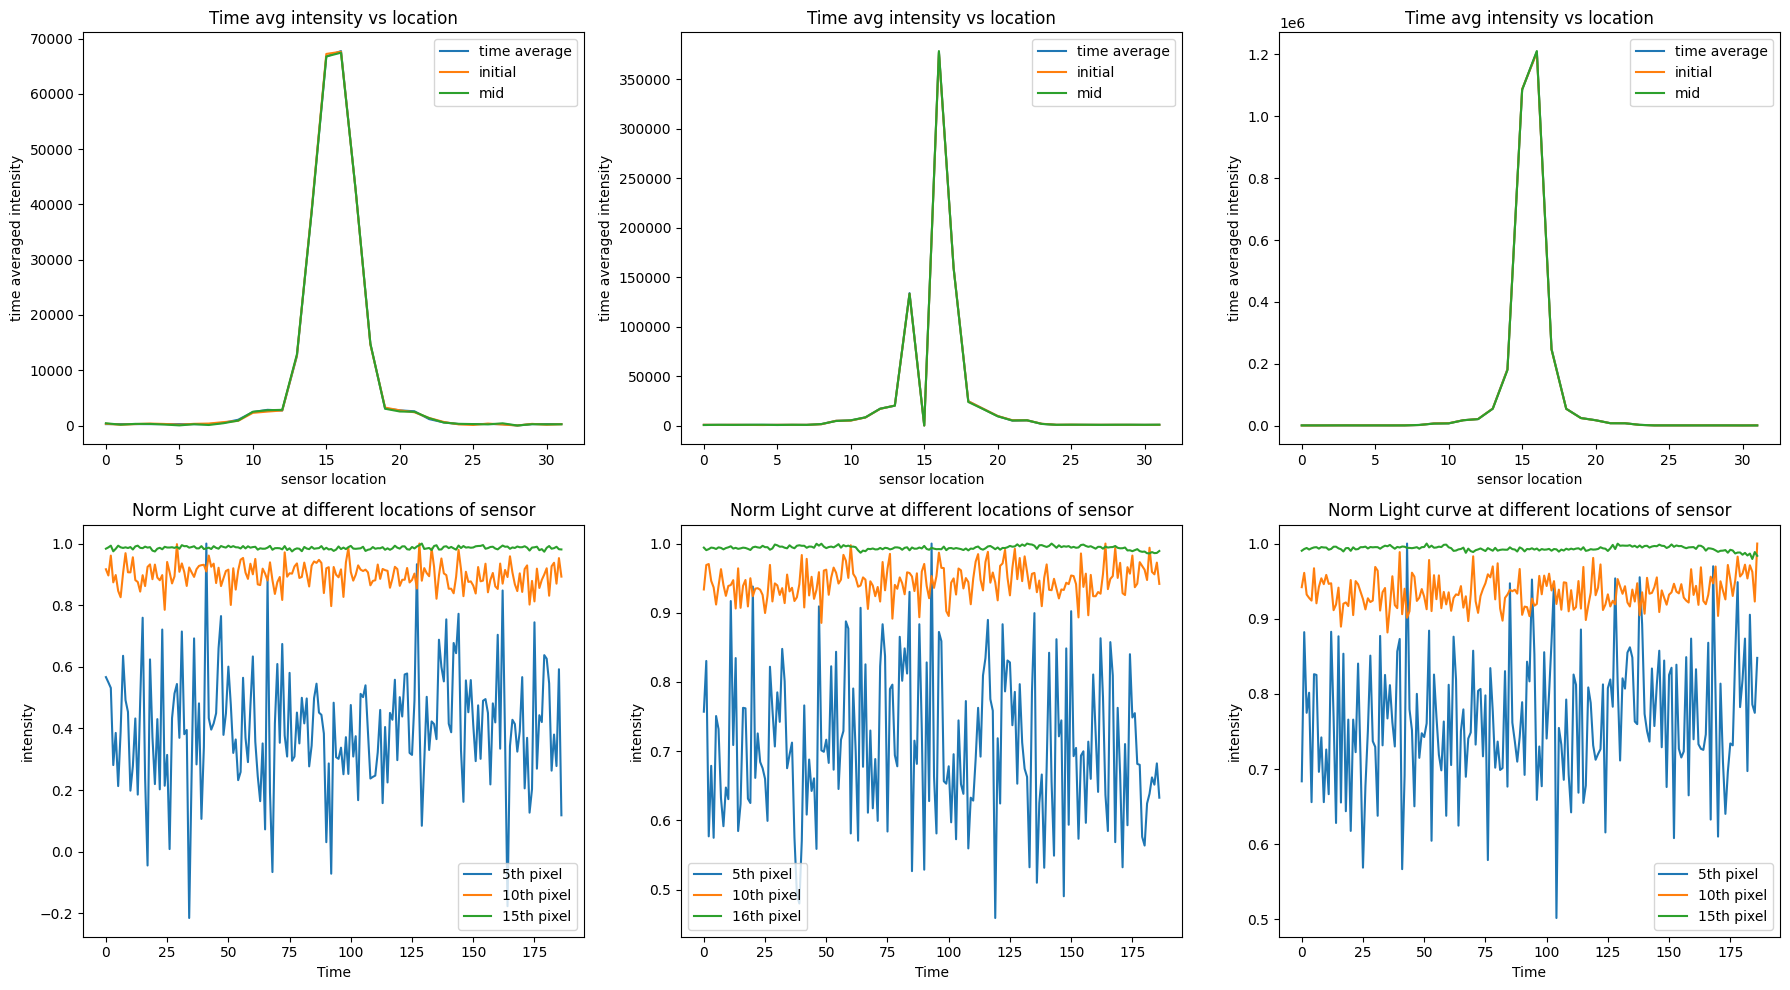

In [606]:
fig, axs = plt.subplots(2, 3, figsize=(18, 10))

axs[0, 0].plot(flux_spatial_1, label="time average")
axs[0, 0].plot(train_df[0][5, wavelength_1, :], label="initial")
axs[0, 0].plot(train_df[0][90, wavelength_1, :], label="mid")
axs[0, 0].set_xlabel("sensor location")
axs[0, 0].set_ylabel("time averaged intensity")
axs[0, 0].set_title("Time avg intensity vs location")
axs[0, 0].legend()

axs[0, 1].plot(flux_spatial_2, label="time average")
axs[0, 1].plot(train_df[0][5, wavelength_2, :], label="initial")
axs[0, 1].plot(train_df[0][90, wavelength_2, :], label="mid")
axs[0, 1].set_xlabel("sensor location")
axs[0, 1].set_ylabel("time averaged intensity")
axs[0, 1].set_title("Time avg intensity vs location")
axs[0, 1].legend()

axs[0, 2].plot(flux_spatial_3, label="time average")
axs[0, 2].plot(train_df[0][5, wavelength_3, :], label="initial")
axs[0, 2].plot(train_df[0][90, wavelength_3, :], label="mid")
axs[0, 2].set_xlabel("sensor location")
axs[0, 2].set_ylabel("time averaged intensity")
axs[0, 2].set_title("Time avg intensity vs location")
axs[0, 2].legend()

axs[1, 0].plot(
    train_df[0][:, wavelength_1, 5] / np.max(train_df[0][:, wavelength_1, 5]),
    label="5th pixel",
)
axs[1, 0].plot(
    train_df[0][:, wavelength_1, 10] / np.max(train_df[0][:, wavelength_1, 10]),
    label="10th pixel",
)
axs[1, 0].plot(
    train_df[0][:, wavelength_1, 15] / np.max(train_df[0][:, wavelength_1, 15]),
    label="15th pixel",
)
axs[1, 0].set_xlabel("Time")
axs[1, 0].set_ylabel("intensity")
axs[1, 0].set_title("Norm Light curve at different locations of sensor")
axs[1, 0].legend()

axs[1, 1].plot(
    train_df[0][:, wavelength_2, 5] / np.max(train_df[0][:, wavelength_2, 5]),
    label="5th pixel",
)
axs[1, 1].plot(
    train_df[0][:, wavelength_2, 10] / np.max(train_df[0][:, wavelength_2, 10]),
    label="10th pixel",
)
axs[1, 1].plot(
    train_df[0][:, wavelength_2, 16] / np.max(train_df[0][:, wavelength_2, 16]),
    label="16th pixel",
)
axs[1, 1].set_xlabel("Time")
axs[1, 1].set_ylabel("intensity")
axs[1, 1].set_title("Norm Light curve at different locations of sensor")
axs[1, 1].legend()

axs[1, 2].plot(
    train_df[0][:, wavelength_3, 5] / np.max(train_df[0][:, wavelength_3, 5]),
    label="5th pixel",
)
axs[1, 2].plot(
    train_df[0][:, wavelength_3, 10] / np.max(train_df[0][:, wavelength_3, 10]),
    label="10th pixel",
)
axs[1, 2].plot(
    train_df[0][:, wavelength_3, 15] / np.max(train_df[0][:, wavelength_3, 15]),
    label="15th pixel",
)
axs[1, 2].set_xlabel("Time")
axs[1, 2].set_ylabel("intensity")
axs[1, 2].set_title("Norm Light curve at different locations of sensor")
axs[1, 2].legend()

plt.tight_layout()
plt.show()

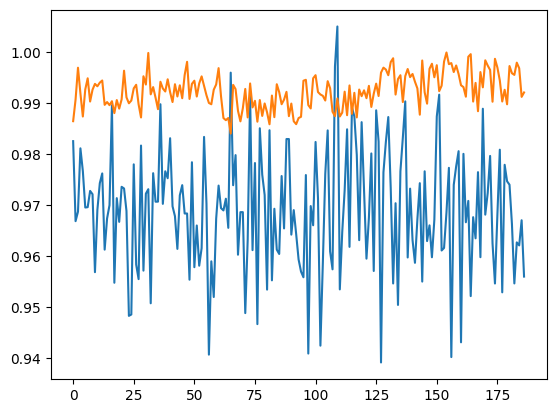

In [607]:
# plt.plot(train_df[0][:, wavelength_1, :].sum(axis=1))
plt.plot(
    (train_df[0][:, wavelength_1, :].sum(axis=1) - train_df[0][:, wavelength_1, 2] * 32)
    / train_df[0][:, wavelength_1, :].sum(axis=1)
)
plt.plot(
    train_df[0][:, wavelength_1, :].sum(axis=1)
    / train_df[0][:, wavelength_1, :].sum(axis=1).max()
)

In [608]:
fgs_data = np.load(f"../data/processed/{target_star}_fgs1.npy")

In [609]:
def image_centroid(image):
    if not isinstance(image, np.ndarray):
        raise ValueError("Input image should be a numpy array")

    # Get the shape of the image
    if len(image.shape) == 2:
        height, width = image.shape

        # Create coordinate grids for x and y
        x_coords = np.arange(width)
        y_coords = np.arange(height)

        # Calculate the total intensity
        total_intensity = np.sum(image)

        if total_intensity == 0:
            # In case the image is completely dark, return None or (0, 0)
            return None

        # Calculate the weighted sum of x and y coordinates
        x_weighted_sum = np.sum(image * x_coords[np.newaxis, :])
        y_weighted_sum = np.sum(image * y_coords[:, np.newaxis])

        # Calculate the centroid coordinates (x_c, y_c)
        x_centroid = x_weighted_sum / total_intensity
        y_centroid = y_weighted_sum / total_intensity

        return x_centroid, y_centroid

    elif len(image.shape) == 1:
        height = image.shape[0]
        y_coords = np.arange(height)

        # Calculate the total intensity
        total_intensity = np.sum(image)

        if total_intensity == 0:
            # In case the image is completely dark, return None or (0, 0)
            return None

        # Calculate the weighted sum of x and y coordinates
        y_weighted_sum = np.sum(image * y_coords)

        # Calculate the centroid coordinates (x_c, y_c)
        y_centroid = y_weighted_sum / total_intensity

        return y_centroid

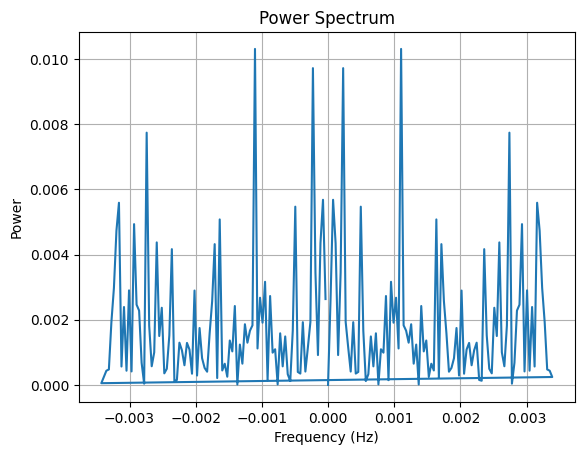

In [610]:
spectrogram_centroid = [
    image_centroid(train_df[0][i, wavelength_2, 10:20]) for i in range(180)
]

fft_result = fft(spectrogram_centroid - np.mean(spectrogram_centroid))
power_spectrum = np.abs(fft_result) ** 2
freqs = fftfreq(len(fft_result), (7.5 * 3600 / 185))

# Plot the power sepctrum
plt.plot(freqs, power_spectrum)
plt.xlabel("Frequency (Hz)")
plt.ylabel("Power")
plt.title("Power Spectrum")
plt.grid(True)
plt.show()

In [611]:
image_centroid_measurements = [image_centroid(fgs_data[0][i])[0] for i in range(187)]

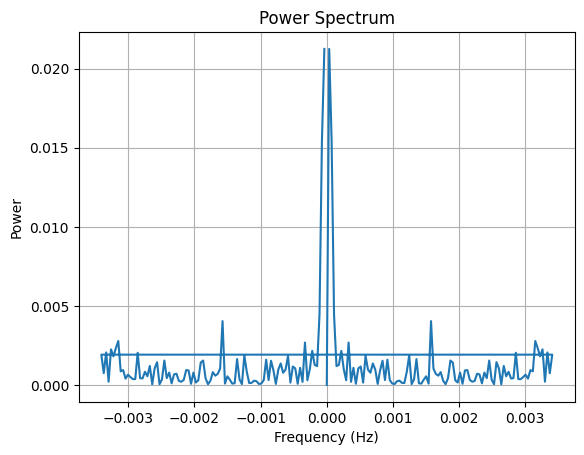

In [612]:
fft_result = fft(image_centroid_measurements - np.mean(image_centroid_measurements))
power_spectrum = np.abs(fft_result) ** 2
freqs = fftfreq(len(fft_result), (7.5 * 3600 / 185))

# Plot the power sepctrum
plt.plot(freqs, power_spectrum)
plt.xlabel("Frequency (Hz)")
plt.ylabel("Power")
plt.title("Power Spectrum")
plt.grid(True)
plt.show()

In [613]:
image_centroid(train_df[0].sum(axis=(1, 2)))

np.float64(93.06132927260785)

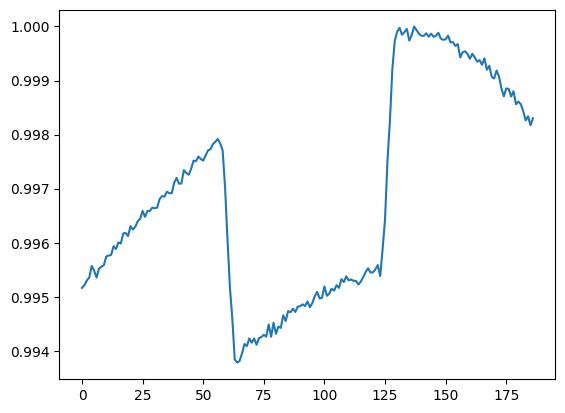

In [614]:
plt.plot(train_df[0].sum(axis=(1, 2)) / max(train_df[0].sum(axis=(1, 2))))

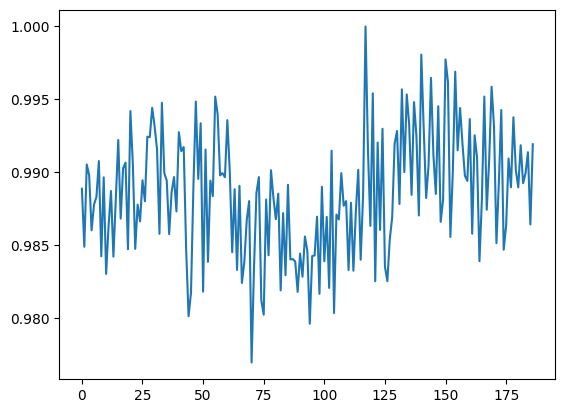

In [616]:
freq = 10
plt.plot(
    train_df[0][:, freq, :].sum(axis=(1)) / max(train_df[0][:, freq, :].sum(axis=(1)))
)

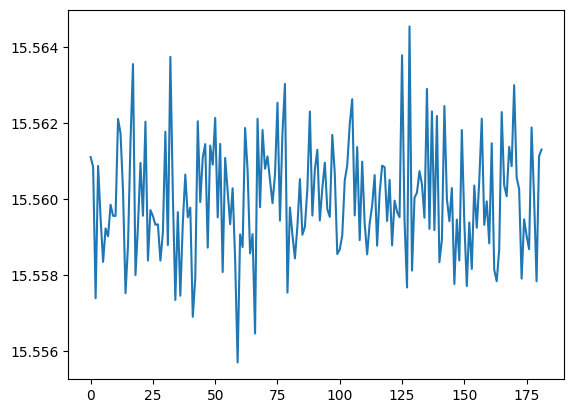

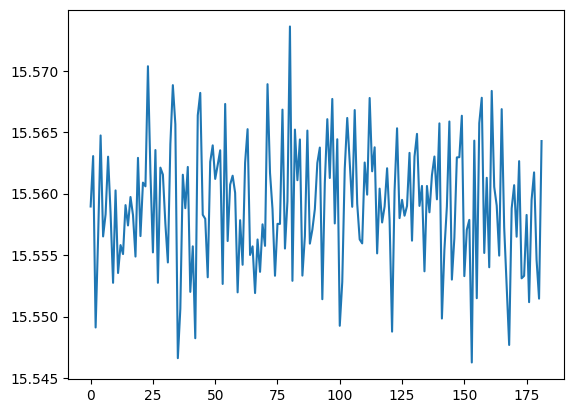

In [617]:
plt.plot([image_centroid(train_df[0][i].sum(axis=(0))) for i in range(182)])
plt.show()
plt.plot([image_centroid(train_df[0][i, 200]) for i in range(182)])
plt.show()

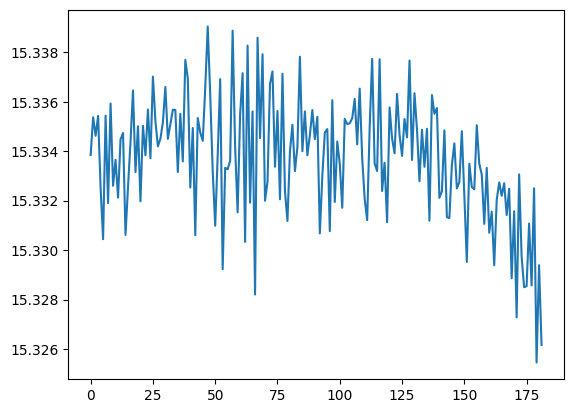

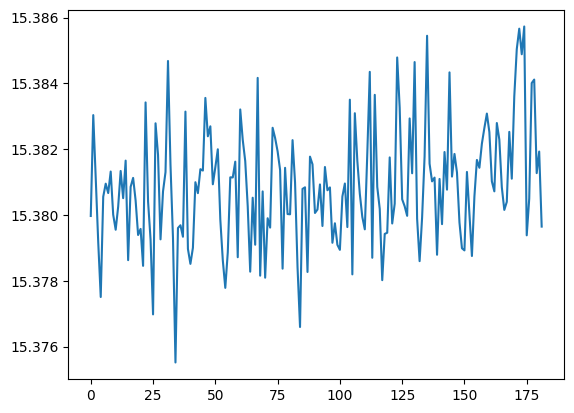

In [618]:
plt.plot([image_centroid(fgs_data[0][i])[0] for i in range(182)])
plt.show()
plt.plot([image_centroid(fgs_data[0][i])[1] for i in range(182)])
plt.show()

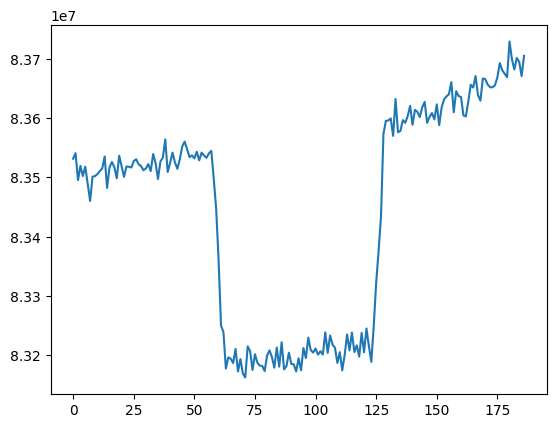

In [621]:
plt.plot(fgs_data[0].sum(axis=(1, 2)))

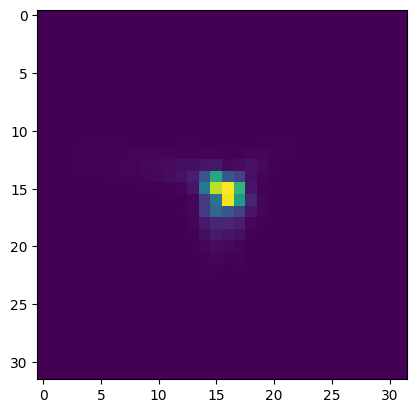

In [619]:
plt.imshow(fgs_data[0][4])

In [375]:
test_curve = train_df[0][:, :, :] - train_df[0][:, :, 2][:, :, np.newaxis]

In [376]:
undisturbed = test_curve[: p1 - buffer, :, :].sum(axis=2).mean(axis=0)
disturbed = test_curve[p1 + buffer : p2 - buffer, :, :].sum(axis=2).mean(axis=0)
ratio = (undisturbed - disturbed) / undisturbed

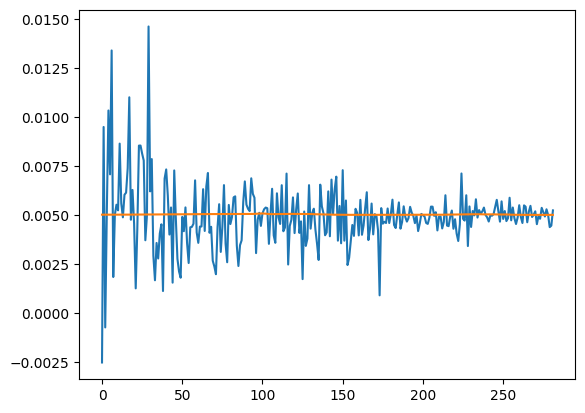

In [377]:
plt.plot(ratio)
plt.plot(gt_df_star)

In [214]:
cleaned_signal = (
    train_df[0][:, wavelength_1, :].sum(axis=1)
    - train_df[0][:, wavelength_1, 1] * 32 * 0
)

item_1 = cleaned_signal[: p1 - buffer].mean()
item_2 = cleaned_signal[p1 + buffer : p2 - buffer].mean()

print((item_1 - item_2) / item_1)

0.001991018315245514


In [215]:
gt_df_star[wavelength_1]

np.float64(0.0009422950891927)

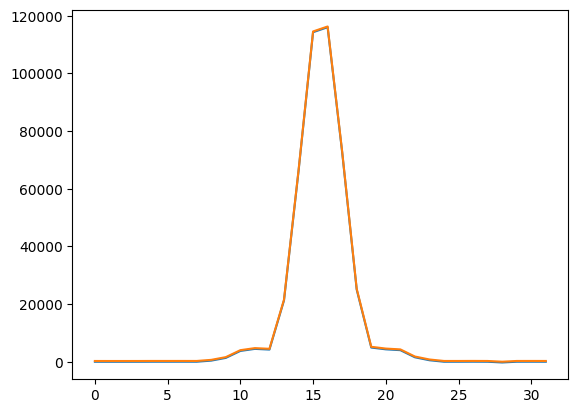

In [216]:
plt.plot(flux_spatial_1 - train_df[0][:, wavelength_1, 5].mean(axis=(0)))
plt.plot(flux_spatial_1)

In [217]:
# Correlations between time series
# spearman_corr_matrix, _ = pearsonr(train_df[0][:,:,:].sum(axis=(2)), axis=0)
norm_time_series = train_df[0][:, :, :].sum(axis=(2)) / train_df[0][:, :, :].sum(
    axis=(2)
).max(axis=0)
pearson_corr_matrix_ts = np.corrcoef(norm_time_series, rowvar=False)

norm_resi_it = train_df[0][p1 + buffer : p2 - buffer, :, :].sum(axis=(2)) - train_df[0][
    p1 + buffer : p2 - buffer, :, :
].sum(axis=(2)).mean(axis=0)
norm_resi_it = norm_resi_it / norm_resi_it.max(axis=0)
pearson_corr_matrix_resi = np.corrcoef(norm_resi_it, rowvar=False)

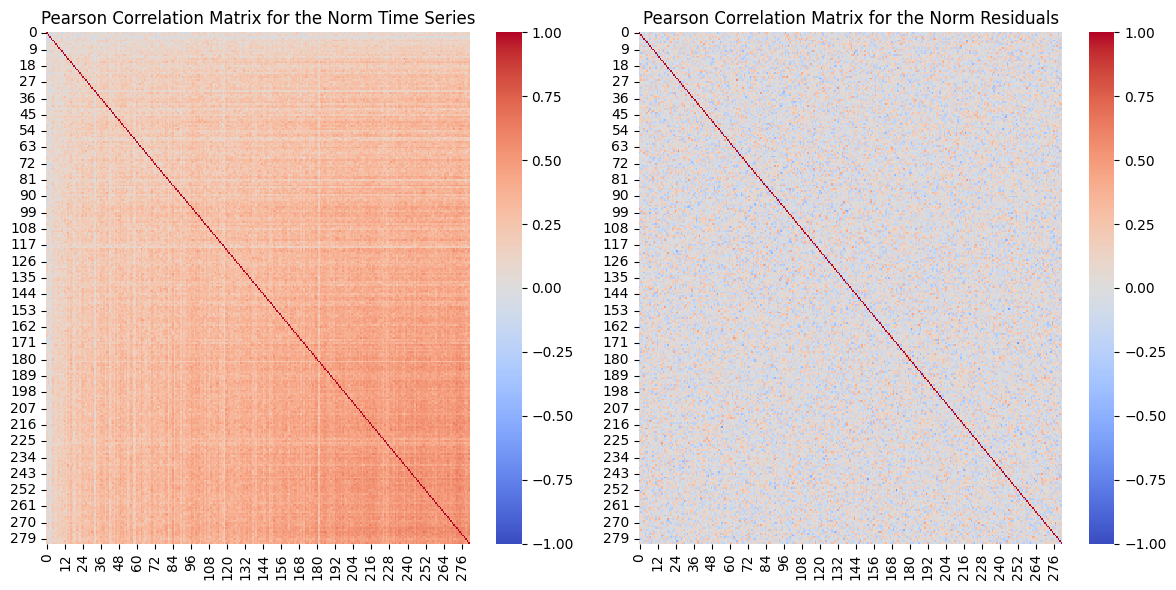

In [219]:
fig, axs = plt.subplots(1, 2, figsize=(12, 6))


# Plot the correlation matrix as a heatmap
sns.heatmap(
    pearson_corr_matrix_ts, annot=False, cmap="coolwarm", vmin=-1, vmax=1, ax=axs[0]
)
axs[0].set_title("Pearson Correlation Matrix for the Norm Time Series")

sns.heatmap(
    pearson_corr_matrix_resi, annot=False, cmap="coolwarm", vmin=-1, vmax=1, ax=axs[1]
)
axs[1].set_title("Pearson Correlation Matrix for the Norm Residuals")

plt.tight_layout()
plt.show()

# Add labels and title

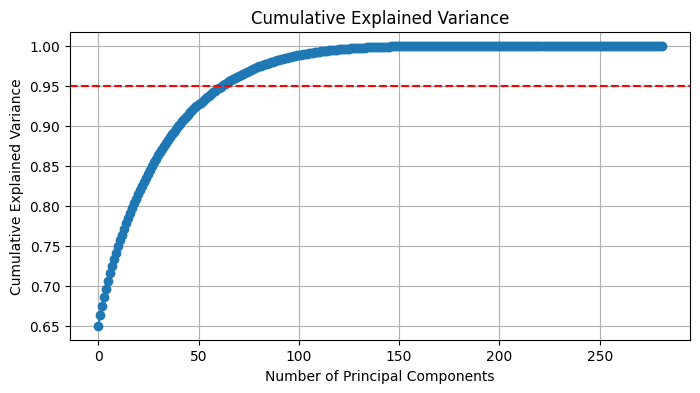

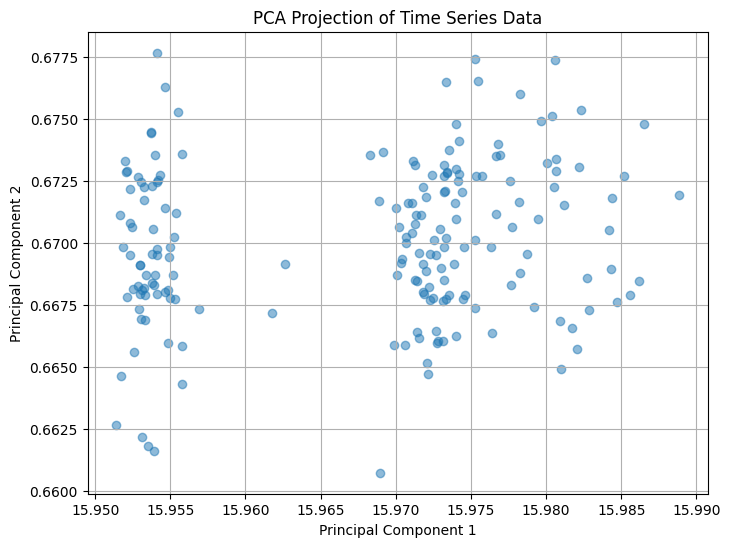

In [220]:
correlation_matrix = pearson_corr_matrix_ts
data = norm_time_series
pca = PCA()
pca.fit(correlation_matrix)

# 3. Get the eigenvalues and eigenvectors
eigenvalues = pca.explained_variance_
eigenvectors = pca.components_

# 4. Sort eigenvalues and eigenvectors
sorted_indices = np.argsort(eigenvalues)[::-1]
eigenvalues_sorted = eigenvalues[sorted_indices]
eigenvectors_sorted = eigenvectors[sorted_indices]

# 5. Select top k principal components
k = 2  # For example, choose the top 2 components
top_eigenvectors = eigenvectors_sorted[:k]

# 6. Project original data onto the principal components
projected_data = data.dot(top_eigenvectors.T)

# Optional: Visualize the explained variance
plt.figure(figsize=(8, 4))
plt.plot(np.cumsum(pca.explained_variance_ratio_), marker="o")
plt.title("Cumulative Explained Variance")
plt.xlabel("Number of Principal Components")
plt.ylabel("Cumulative Explained Variance")
plt.grid()
plt.axhline(y=0.95, color="r", linestyle="--")  # 95% variance threshold
plt.show()

# Optional: Plot the projected data
plt.figure(figsize=(8, 6))
plt.scatter(projected_data[:, 0], projected_data[:, 1], alpha=0.5)
plt.title("PCA Projection of Time Series Data")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.grid()
plt.show()

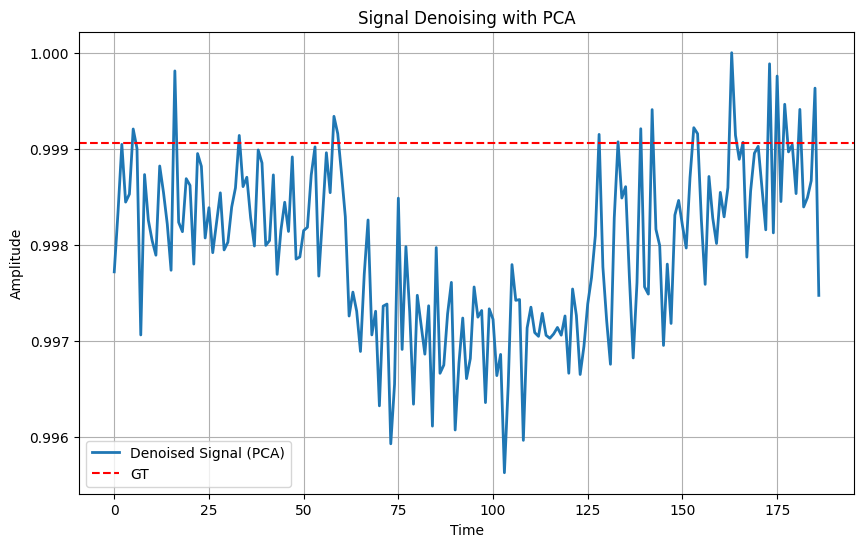

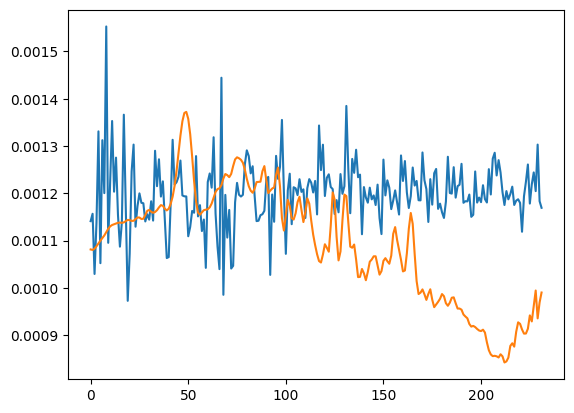

In [222]:
k = 3  # Retain only 1 principal component
reduced_data = pca.transform(data)[:, :k]  # Project data onto the first k PCs
reconstructed_signal = pca.inverse_transform(
    np.hstack((reduced_data, np.zeros((reduced_data.shape[0], data.shape[1] - k))))
)
reconstructed_signal_norm = reconstructed_signal / reconstructed_signal.max(axis=0)

test_wavelength = wavelength_1


# 3. Plot the original, noisy, and denoised signals
plt.figure(figsize=(10, 6))

plt.plot(
    range(187),
    reconstructed_signal_norm[:, test_wavelength],
    label="Denoised Signal (PCA)",
    linewidth=2,
)
plt.axhline(y=1 - gt_df_star[test_wavelength], color="r", linestyle="--", label="GT")
plt.xlabel("Time")
plt.ylabel("Amplitude")
plt.title("Signal Denoising with PCA")
plt.legend()
plt.grid()
plt.show()

reconstructed_spectrum = (
    reconstructed_signal_norm[: p1 - buffer, :].mean(axis=0)
    - reconstructed_signal_norm[p1 + buffer : p2 - buffer, :].mean(axis=0)
) / reconstructed_signal_norm[: p1 - buffer, :].mean(axis=0)

plt.plot(reconstructed_spectrum[50:])
plt.plot(gt_df_star[50:])

In [223]:
# Model the noise / residual of light curves
lc_resi_it_raw_1 = lc_raw_1[p1 + buffer : p2 - buffer] - lc_raw_it_1
lc_resi_it_raw_2 = lc_raw_2[p1 + buffer : p2 - buffer] - lc_raw_it_2
lc_resi_it_raw_3 = lc_raw_3[p1 + buffer : p2 - buffer] - lc_raw_it_3

lc_resi_oot_raw_1 = (
    np.hstack((lc_raw_1[: p1 - buffer], lc_raw_1[p2 + buffer :])) - lc_raw_oot_1
)
lc_resi_oot_raw_2 = (
    np.hstack((lc_raw_2[: p1 - buffer], lc_raw_2[p2 + buffer :])) - lc_raw_oot_2
)
lc_resi_oot_raw_3 = (
    np.hstack((lc_raw_3[: p1 - buffer], lc_raw_3[p2 + buffer :])) - lc_raw_oot_3
)

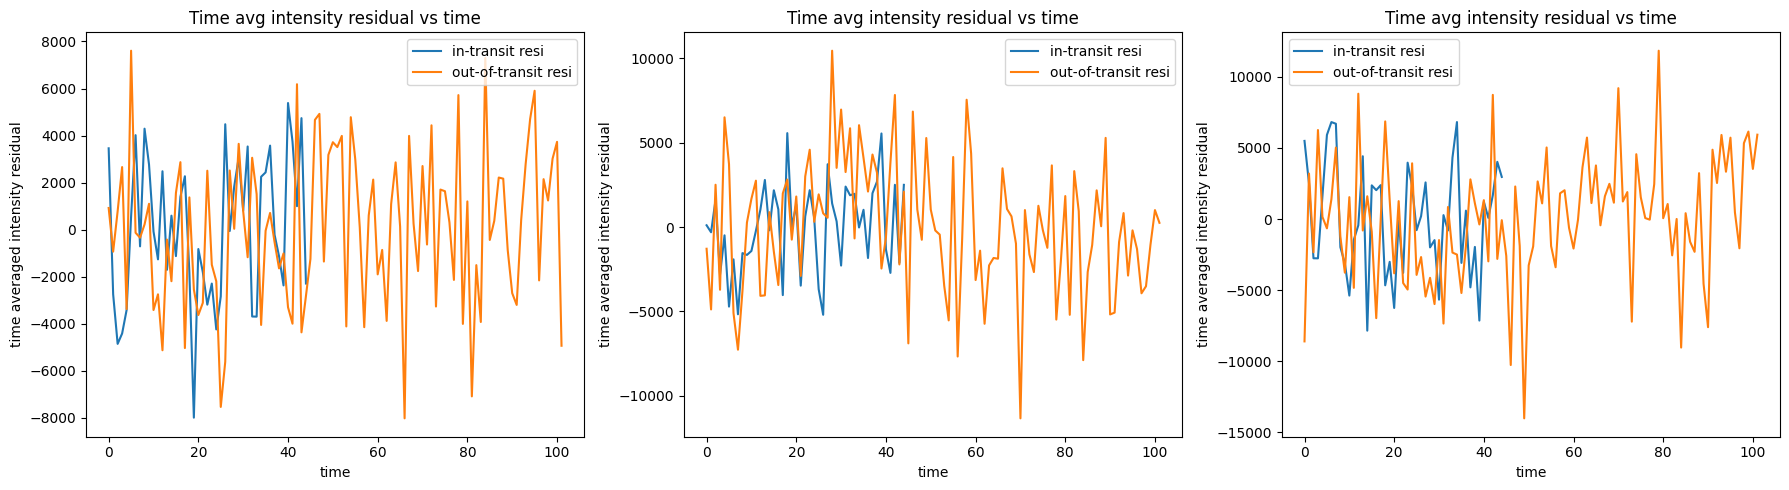

In [224]:
fig, axs = plt.subplots(1, 3, figsize=(18, 5))

axs[0].plot(lc_resi_it_raw_1, label="in-transit resi")
axs[0].plot(lc_resi_oot_raw_1, label="out-of-transit resi")
axs[0].set_xlabel("time")
axs[0].set_ylabel("time averaged intensity residual")
axs[0].set_title("Time avg intensity residual vs time")
axs[0].legend()

axs[1].plot(lc_resi_it_raw_2, label="in-transit resi")
axs[1].plot(lc_resi_oot_raw_2, label="out-of-transit resi")
axs[1].set_xlabel("time")
axs[1].set_ylabel("time averaged intensity residual")
axs[1].set_title("Time avg intensity residual vs time")
axs[1].legend()

axs[2].plot(lc_resi_it_raw_3, label="in-transit resi")
axs[2].plot(lc_resi_oot_raw_3, label="out-of-transit resi")
axs[2].set_xlabel("time")
axs[2].set_ylabel("time averaged intensity residual")
axs[2].set_title("Time avg intensity residual vs time")
axs[2].legend()

plt.tight_layout()
plt.show()

In [225]:
def fft_spectrum(signal, sampling_rate):
    fft_result = fft(signal)
    power_spectrum = np.abs(fft_result) ** 2
    freqs = fftfreq(len(signal), (1 / sampling_rate))
    return power_spectrum, freqs

In [226]:
fft_it_spec_1, freqs = fft_spectrum(lc_resi_it_raw_1, sampling_rate)
fft_it_spec_2, freqs = fft_spectrum(lc_resi_it_raw_2, sampling_rate)
fft_it_spec_3, freqs = fft_spectrum(lc_resi_it_raw_3, sampling_rate)

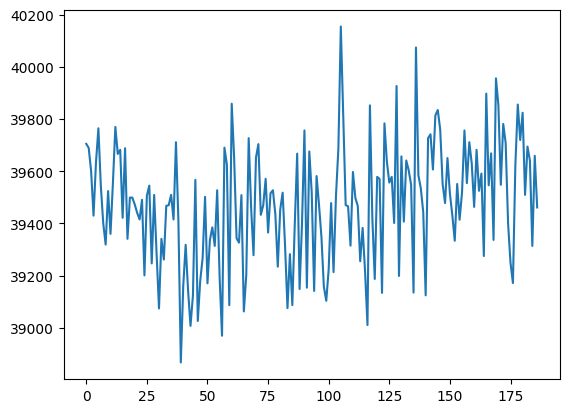

In [227]:
plt.plot(train_df[0][:, 0, 16])

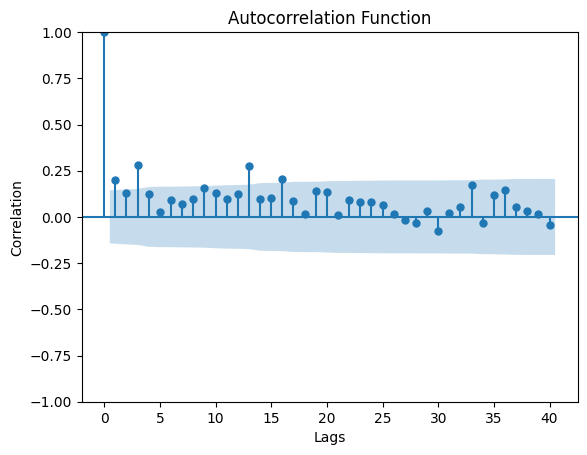

In [228]:
tsaplots.plot_acf(train_df[0][:, 0, 16], lags=40)
plt.title("Autocorrelation Function")
plt.xlabel("Lags")
plt.ylabel("Correlation")
plt.show()

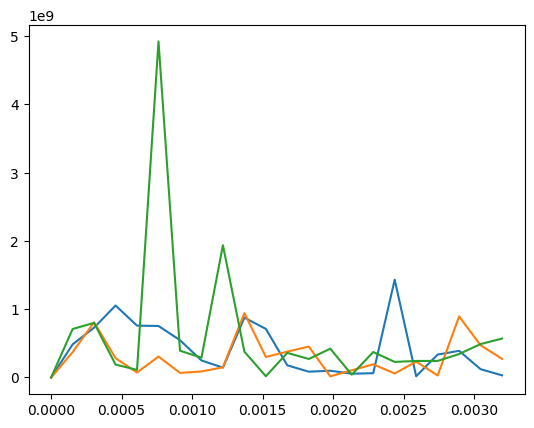

In [229]:
plt.plot(freqs[: len(freqs) // 2], fft_it_spec_1[: len(fft_it_spec_1) // 2])
plt.plot(freqs[: len(freqs) // 2], fft_it_spec_2[: len(fft_it_spec_2) // 2])
plt.plot(freqs[: len(freqs) // 2], fft_it_spec_3[: len(fft_it_spec_3) // 2])
plt.show()

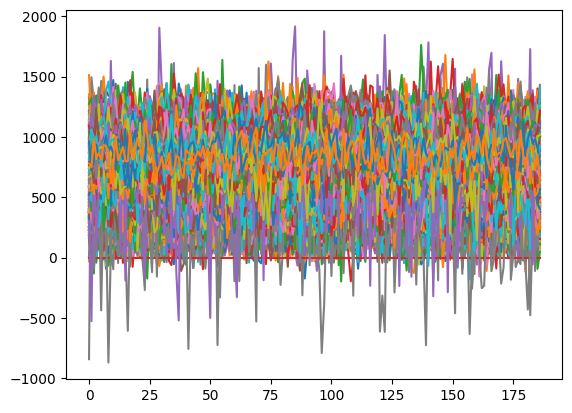

In [230]:
# are there trends seen in the edege of the flux measured by AIRS?
plt.plot(train_df[0][:, :, 0])

In [231]:
in_transit = train_df[0][70:110]
oot = np.concatenate([train_df[0][0:50], train_df[0][140:]], axis=0)
it = train_df[0][70:110]

cutoff_freq = 0.001  # Hz
sampling_rate = 1 / (7.5 * 3600 / 185)  # Hz
order = 4

In [150]:
signal = train_df[0][:, :, 10:20].sum(axis=2)
norm_signal = signal - np.mean(signal, axis=0)
signal_cleaned = denoising_models.fft_smmoothing(
    norm_signal, sampling_rate, order, cutoff_freq
) + np.mean(signal, axis=0)

results = denoising_models.calibrate_train(signal)

In [151]:
# The spectral absorption can not be less than a certain floor - that given by the overall white curve. We need to correct for this

avg_depth = (oot.sum(axis=(1, 2)).mean() - it.sum(axis=(1, 2)).mean()) / oot.sum(
    axis=(1, 2)
).mean()


s_result = [max(0.000, results[i][0]) for i in range(len(results))]

prediction_1 = [None for _ in range(len(oot))]

place_holder_count = 0
positive_count = 0
for i in range(len(prediction_1)):
    if np.sum(oot[:, i], axis=1).min() < np.sum(it[:, i], axis=1).max():
        prediction_1[i] = -1
        place_holder_count += 1
    else:
        prediction_1[i] = max(avg_depth, (oot[i] - it[i]) / (oot[i] + 1e-10))
        positive_count += prediction_1[i]

new_placeholder = (avg_depth * len(prediction_1) - positive_count) / place_holder_count

prediction_1 = [
    prediction_1[i] if prediction_1[i] > 0 else new_placeholder
    for i in range(len(prediction_1))
]

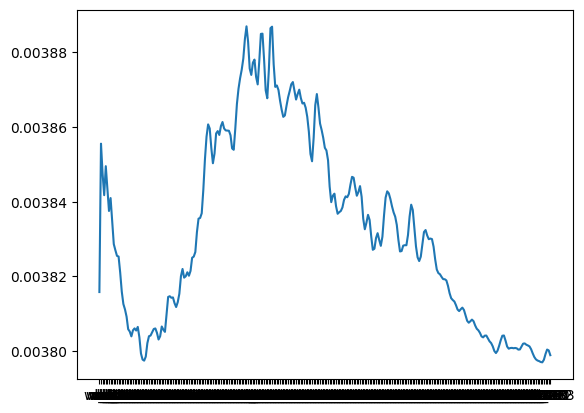

In [152]:
# There maybe reasons why there should be "smoothness" in the spectrogram. Unclear as see example below
def average_closest_five_numpy(arr):
    n = len(arr)
    result = np.zeros(n)
    for i in range(n):
        left = max(0, i - 4)
        right = min(n - 1, i + (8 - (i - left)))
        window = arr[left : right + 1]
        result[i] = np.mean(window)
    return result


plt.plot(gt_df.iloc[50, 1:])
plt.show()

0.00600256340291429


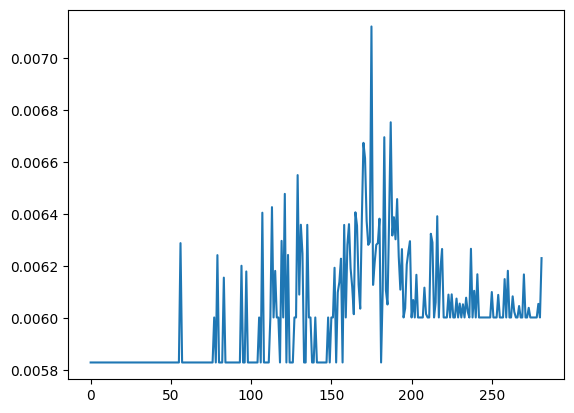

In [28]:
oot = train_df[0][:49, :, 10:20]
it = train_df[0][70:110, :, 10:20]
avg_depth = (oot.sum(axis=(1, 2)).mean() - it.sum(axis=(1, 2)).mean()) / oot.sum(
    axis=(1, 2)
).mean()
print(avg_depth)
oot_1 = np.mean(np.sum(oot, axis=2), axis=0)
it_1 = np.mean(np.sum(it, axis=2), axis=0)

prediction_1 = [None for _ in range(len(oot_1))]

place_holder_count = 0
positive_count = 0
for i in range(len(prediction_1)):
    if np.sum(oot[:, i], axis=1).min() < np.sum(it[:, i], axis=1).max():
        prediction_1[i] = -1
        place_holder_count += 1
    else:
        prediction_1[i] = max(avg_depth, (oot_1[i] - it_1[i]) / (oot_1[i] + 1e-10))
        positive_count += prediction_1[i]

new_placeholder = (avg_depth * len(prediction_1) - positive_count) / place_holder_count

prediction_1 = [
    prediction_1[i] if prediction_1[i] > 0 else new_placeholder
    for i in range(len(prediction_1))
]

# prediction_1 = (oot_1 - it_1) / (oot_1 + 1e-10)
plt.plot(prediction_1)
plt.show()

In [19]:
signal_poly = np.sum(train_df[0], axis=2) - np.mean(
    np.sum(train_df[0], axis=2), axis=0, keepdims=True
)
signal_poly = denoising_models.fft_smmoothing(
    signal_poly, sampling_rate, order, cutoff_freq
) + np.mean(np.sum(train_df[0], axis=2), axis=0)

In [29]:
plt.plot(signal_poly.mean(axis=1))

NameError: name 'signal_poly' is not defined

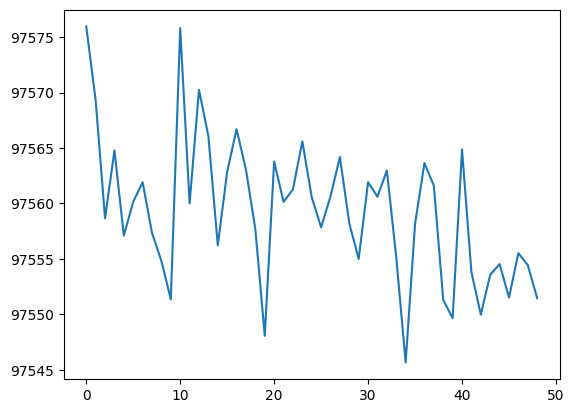

NameError: name 'oot_3' is not defined

In [30]:
# plt.plot(oot[:,1,:].sum(axis=1))
plt.plot(np.mean(oot, axis=(1, 2)))
plt.show()

plt.plot(np.sum(oot_3, axis=(1)))
plt.show()

plt.plot(np.sum(oot_4, axis=(1)))
plt.show()


fft_result = fft(oot_2[:, 1])
power_spectrum = np.abs(fft_result) ** 2
freqs = fftfreq(len(oot_2), (7.5 * 3600 / 185))
plt.plot(freqs[:], power_spectrum[:])

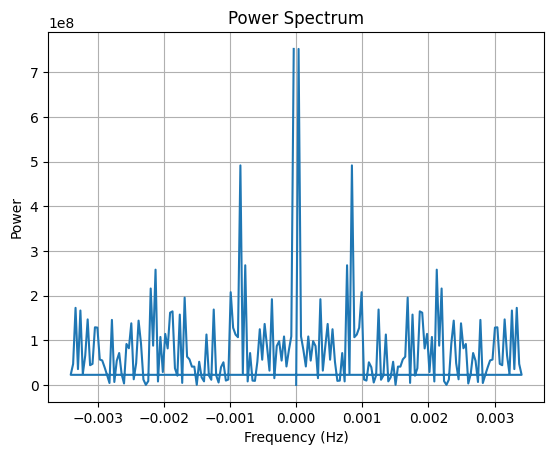

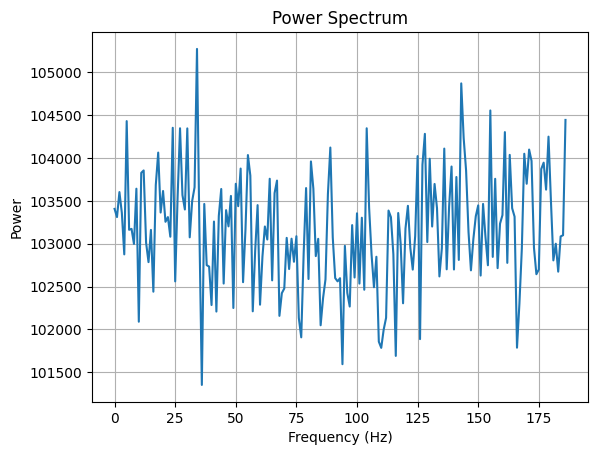

AttributeError: 'numpy.ndarray' object has no attribute 'spectrogram'

In [212]:
fft_result = fft(oot_2[:, 1])
power_spectrum = np.abs(fft_result) ** 2
freqs = fftfreq(len(oot_2), (7.5 * 3600 / 185))

# Plot the power sepctrum
plt.plot(freqs, power_spectrum)
plt.xlabel("Frequency (Hz)")
plt.ylabel("Power")
plt.title("Power Spectrum")
plt.grid(True)
plt.show()


# Plot the light curve
plt.plot(train_df[0][:, 1, :].sum(axis=1))
plt.xlabel("Frequency (Hz)")
plt.ylabel("Power")
plt.title("Power Spectrum")
plt.grid(True)
plt.show()

# plot the light curve
f, t, Sxx = signal.spectrogram(
    train_df[0][:, 1].sum(axis=1),
    fs=(1 / (7.5 * 3600 / len(train_df[0][1]))),
    nperseg=50,
)
plt.pcolormesh(t, f, 10 * np.log10(Sxx))
plt.ylabel("Frequency (Hz)")
plt.xlabel("Time (s)")
plt.colorbar(label="Power Spectral Density (dB)")
plt.title("Spectrogram")
plt.show()

In [201]:
# Assuming train_df is your DataFrame
time_series = train_df[0][:, 1].sum(axis=1)

wavelet_name = "db4"
decomposition_level = 5

# Use pywavelets.wavedec
coeffs = pywt.wavedec(
    time_series - np.mean(time_series), wavelet_name, level=decomposition_level
)

# Apply thresholding (the same as before)
threshold = 0.5 * np.median(np.abs(coeffs[-1])) * np.sqrt(2 * np.log(len(time_series)))
coeffs = [pywt.threshold(c, threshold, mode="soft") for c in coeffs]

# Use pywavelets.waverec
denoised_time_series = pywt.waverec(coeffs, wavelet_name)

/opt/miniconda3/envs/KaggleAriel/lib/python3.12/site-packages/pywt/_multilevel.py:43: UserWarning: Level value of 5 is too high: all coefficients will experience boundary effects.
  warnings.warn(


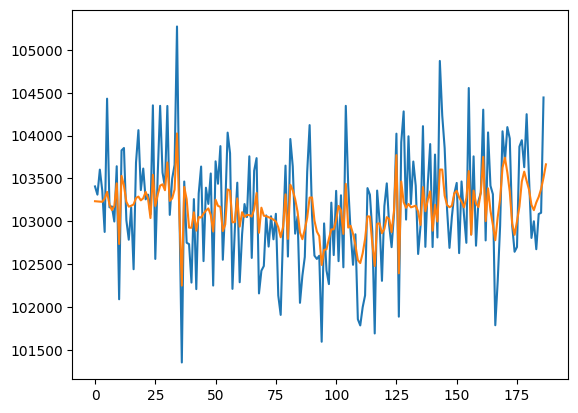

In [202]:
plt.plot(time_series)
plt.plot(denoised_time_series + np.mean(time_series))

(187,)
(187, 282)


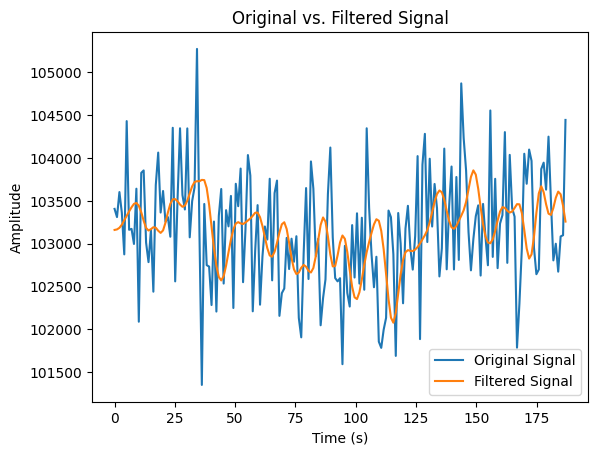

In [205]:
test_signal = train_df[0].sum(axis=2)
# Design a low-pass filter (adjust cutoff frequency as needed)
cutoff_freq = 0.001  # Hz
sampling_rate = 1 / (7.5 * 3600 / len(test_signal[0]))  # Hz
order = 4

b, a = butter(order, cutoff_freq, fs=sampling_rate, btype="lowpass")

# Apply the filter
filtered_signal = lfilter(b, a, test_signal[:, 1] - np.mean(test_signal[:, 1]))
print(filtered_signal.shape)
print(test_signal.shape)

time = np.linspace(0, 187, 1 * 187)

# Plot the original and filtered signals
plt.plot(time, test_signal[:, 1], label="Original Signal")
# plt.show()

plt.plot(time, filtered_signal + np.mean(test_signal[:, 1]), label="Filtered Signal")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.legend()
plt.title("Original vs. Filtered Signal")

plt.show()